In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import numpy as np
import os

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
#class torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
#transforms.RandomResizedCrop(224) --> A crop of random size (default: of 0.08 to 1.0) of the original size and a 
#random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. 
#This crop is finally resized to given size (224 in this case). 
#transforms.CenterCrop(224)--> Crops the image at the center. 224 is the Desired output size of the crop.
#class torchvision.transforms.Normalize(mean, std)
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, 
#this transform will normalize each channel of the input torch.Tensor i.e. 
#input[channel] = (input[channel] - mean[channel]) / std[channel]
#Parameters:     mean (sequence) – Sequence of means for each channel.
#                std (sequence) – Sequence of standard deviations for each channel.

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), #Crop the given PIL Image to random size and aspect ratio.
        transforms.RandomHorizontalFlip(), #Horizontally flip the given PIL Image randomly with a given probability.
        transforms.ToTensor(), #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.Normalize([0.485, 0.456, 0.406], #Normalize a tensor image with mean and standard deviation.
                                [0.229, 0.224, 0.225]) #Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels,
                                                        #this transform will normalize each channel of the input torch.Tensor
                                                        #i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), #Resize the input PIL Image to the given size.
        transforms.CenterCrop(224), #Crops the image at the center. 224 is the Desired output size of the crop.
        transforms.ToTensor(), #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.Normalize([0.485, 0.456, 0.406], #Normalize a tensor image with mean and standard deviation.
                                [0.229, 0.224, 0.225]) #Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels,
                                                        #this transform will normalize each channel of the input torch.Tensor
                                                        #i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]
    ]),
}


    

In [3]:
data_dir = 'data/hymenoptera_data'
# create a dictionary that contains the datasets for training and validation
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# create a dictionary that contains the dataloaders for training and validation
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
# create a dictionary that contains the size of the datasets for training and validation
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# create a list that contains the names of the classes
class_names = image_datasets['train'].classes
# print the names and sizes of the datasets
print(f"Class Names: {class_names}")
print(f"Dataset Sizes: {dataset_sizes}")
print(f"Batches in training set: {len(dataloaders['train'])}")
print(f"Batches in validation set: {len(dataloaders['val'])}")

Class Names: ['ants', 'bees']
Dataset Sizes: {'train': 244, 'val': 153}
Batches in training set: 61
Batches in validation set: 39


In [4]:
# load the resnet18 model
model_conv = models.resnet18(pretrained=True)
# print the model
print(model_conv)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\Raj\repos\nn-bc\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Raj\repos\nn-bc\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# freeze all the layers in the network
for param in model_conv.parameters():
    param.requires_grad = False

In [6]:
# get the number of inputs of the last layer (or number of neurons in the layer preceeding the last layer)
num_ftrs = model_conv.fc.in_features
# replace the last layer with a new layer that has 2 neurons (one for each class)
model_conv.fc = nn.Linear(num_ftrs, 2)

In [7]:
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [8]:
# Understand what is happening in the code below
iteration = 0
correct = 0
for inputs, labels in dataloaders['train']:
    if iteration == 1:
        break
    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())
    # print(f"Inputs: {inputs}")
    print(f"Inputs Shape: {inputs.shape}")
    print(f"Labels: {labels}")
    print(f"Labels Shape: {labels.shape}")
    output = model_conv(inputs)
    print(f"Output Tensor: {output}")
    print(f"Output Shape: {output.shape}")
    _, predicted = torch.max(output, 1)
    print(f"Predicted: {predicted}")
    print(f"Predicted Shape: {predicted.shape}")
    correct += (predicted == labels).sum()
    print(f"Correct Predictions: {correct}")

    iteration += 1

Inputs Shape: torch.Size([4, 3, 224, 224])
Labels: tensor([1, 0, 0, 1], device='cuda:0')
Labels Shape: torch.Size([4])
Output Tensor: tensor([[-0.3763,  0.5220],
        [-0.0712,  0.3410],
        [ 0.5083,  1.0289],
        [ 0.2403,  0.8047]], device='cuda:0', grad_fn=<AddmmBackward0>)
Output Shape: torch.Size([4, 2])
Predicted: tensor([1, 1, 1, 1], device='cuda:0')
Predicted Shape: torch.Size([4])
Correct Predictions: 2


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# try experimenting with different values of lr and momentum
# decay lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
# Understand what is happening in the code above of scheduler.step()
def lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))
    print(f"Learning Rate: {lr}")
    if epoch % lr_decay_epoch == 0:
        print(f"Learning Rate Changed to: {lr}")
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    return optimizer

In [11]:
num_epochs = 25
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    # reset the correct to 0 at the beginning of each epoch
    correct = 0
    for images, labels in dataloaders['train']:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model_conv(images)
        # calculate the loss
        loss = criterion(outputs, labels)
        # backpropagation: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # get the predicted class from the maximum value in the output-list of class scores
        _, predicted = torch.max(outputs.data, 1)
        # calculate the accuracy
        correct += (predicted == labels.data).sum()
    train_acc = 100 * correct / dataset_sizes['train']
    print(f"Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_acc}%")
    

c:\Users\Raj\repos\nn-bc\venv\Lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/25, Training Accuracy: 68.03278350830078%
Epoch 2/25, Training Accuracy: 72.54097747802734%
Epoch 3/25, Training Accuracy: 72.95081329345703%
Epoch 4/25, Training Accuracy: 77.86885070800781%
Epoch 5/25, Training Accuracy: 84.42622375488281%
Epoch 6/25, Training Accuracy: 84.01638793945312%
Epoch 7/25, Training Accuracy: 84.8360595703125%
Epoch 8/25, Training Accuracy: 79.91802978515625%
Epoch 9/25, Training Accuracy: 86.47540283203125%
Epoch 10/25, Training Accuracy: 84.42622375488281%
Epoch 11/25, Training Accuracy: 84.8360595703125%
Epoch 12/25, Training Accuracy: 86.47540283203125%
Epoch 13/25, Training Accuracy: 83.60655212402344%
Epoch 14/25, Training Accuracy: 87.70491027832031%
Epoch 15/25, Training Accuracy: 85.24589538574219%
Epoch 16/25, Training Accuracy: 91.39344024658203%
Epoch 17/25, Training Accuracy: 84.42622375488281%
Epoch 18/25, Training Accuracy: 85.24589538574219%
Epoch 19/25, Training Accuracy: 86.47540283203125%
Epoch 20/25, Training Accuracy: 85.2458953

In [12]:
# test the model on the test set
model_conv.eval()
with torch.no_grad():
    correct = 0
    for (images, labels) in dataloaders['val']:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
    test_acc = 100 * correct / dataset_sizes['val']
    print(f"Test Accuracy: {test_acc}%")

Test Accuracy: 93.46405029296875%


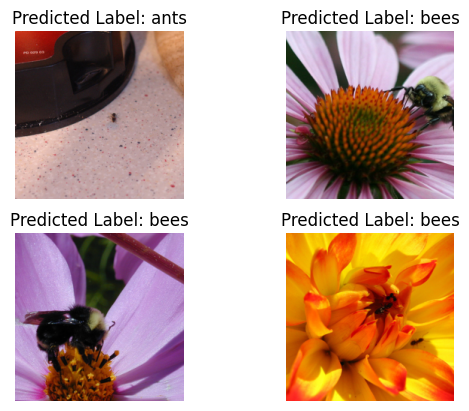

In [15]:
# Visualize some predictions
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for(images, labels) in dataloaders['val']:
        if shown_batch == 1:
            break
        shown_batch += 1
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        outputs = model_conv(images)
        _, preds = torch.max(outputs.data, 1)
        for i in range(4):
            index += 1
            ax = plt.subplot(2, 2, index)
            ax.axis('off')
            ax.set_title(f"Predicted Label: {class_names[preds[i]]}")
            input_img = images.cpu().data[i]
            inp = input_img.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)